In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from pprint import pprint
import pickle
import time
import datetime

In [2]:
# Import qubit states Zero (|0>) and One (|1>), and Pauli operators (X, Y, Z)
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter
# from qiskit.tools.monitor import job_monitor
from qiskit.compiler import transpile
from qiskit.transpiler.passes import RemoveBarriers

In [3]:
# Import state tomography modules
from qiskit_experiments.library import StateTomography
from osp_solutions.patch_ignis import rename_qcs_StateTomography_to_ignis
from osp_solutions.tomography import StateTomographyFitter
from qiskit.quantum_info import state_fidelity

In [4]:
from osp_solutions.circuits import append_block_trotter, append_block_trotter_proposed, append_initial_state, append_block_trotter_aj, append_block_trotter_negishi
from osp_solutions.simulator_dm import make_dm_binary, hamiltonian_to_dm, DMExtended
from osp_solutions.hamiltonian import Hamiltonian, make_H_Heisenberg
from osp_solutions.backend_simulator import result_to_dms

In [5]:
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, pauli_error
# from qiskit_ibm_runtime.fake_provider import FakeJakartaV2
# backend = AerSimulator.from_backend(FakeJakartaV2())
# backend = Aer.get_backend("qasm_simulator")
p_dep1 = 0 # 1.0 * 1e-4
error_dep1 = pauli_error([("I", 1 - 3 * p_dep1 / 4), ("X", p_dep1 / 4), ("Y", p_dep1 / 4), ("Z", p_dep1 / 4)])
# error_dep2_local = error_dep1.tensor(error_dep1)

p_dep2 = 0 # 1.0 * 1e-3
error_dep2_global = pauli_error([("II", 1 - 15 * p_dep2 / 16), ("IX", p_dep2 / 16), ("IY", p_dep2 / 16), ("IZ", p_dep2 / 16),
                                 ("XI", p_dep2 / 16), ("XX", p_dep2 / 16), ("XY", p_dep2 / 16), ("XZ", p_dep2 / 16),
                                 ("YI", p_dep2 / 16), ("YX", p_dep2 / 16), ("YY", p_dep2 / 16), ("YZ", p_dep2 / 16),
                                 ("ZI", p_dep2 / 16), ("ZX", p_dep2 / 16), ("ZY", p_dep2 / 16), ("ZZ", p_dep2 / 16)])

# print(error_dep2_global)

# Add errors to noise model
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(error_dep1, ["rx", "rz", "sx", "h", "sdg", "s", "x", "u1", "u2", "u3"])
noise_model.add_all_qubit_quantum_error(error_dep2_global, ["cz"])
# noise_model.add_all_qubit_quantum_error(error_3, ["cswap", "ccx"])
print(noise_model)
print()

# Create noisy simulator backend
simulator_noisy = AerSimulator(method="density_matrix",
                               noise_model=noise_model)
simulator_ideal = AerSimulator(method="density_matrix")

NoiseModel: Ideal



# Theoretical

In [6]:
num_qubits = 3

# The final time of the state evolution
time_evolution = np.pi / 3

# Parameterize variable t to be evaluated at t=pi later
dt = Parameter('t')

# initial layout
# initial_layout = [5,3,1]
initial_layout = list(range(num_qubits))

# Number of trotter steps
num_steps_list = [4,10,50,100,200] # ,20,30,40,50] # ,60,70,80,90,100]
# num_steps_list = [100]
print("trotter step list: ", num_steps_list)

# scale_factors = [1.0, 2.0, 3.0] # unused for this file

# shots = 1 << 13
reps = 1

state_initial_str = "110" ### specify initial state
state_initial_dm = DMExtended(matrix=make_dm_binary(str_binary=state_initial_str, 
                                                    endian_binary="little_endian", 
                                                    endian_dm="big_endian")) ### make the density matrix for the initial state

H_Heisenberg = make_H_Heisenberg(num_qubits=num_qubits) ### create Heisenberg Hamiltonian in a dictionary format
matrix_Heisenberg = hamiltonian_to_dm(hamiltonian=H_Heisenberg) ### convert Heisenberg Hamiltonian to its matrix form

U_Heisenberg = DMExtended(sp.linalg.expm(-1.0j * matrix_Heisenberg * time_evolution)) ### prepare the unitary matrix of the Heisenberg Hamiltonian

state_target_dm = state_initial_dm.apply_unitary(U_Heisenberg) ### apply the unitary evolution to the density matrix
state_target_dm.is_valid()

trotter step list:  [4, 10, 50, 100, 200]


True

In [7]:
state_initial_dm.draw("latex")

<IPython.core.display.Latex object>

In [8]:
state_target_dm.draw("latex")

<IPython.core.display.Latex object>

# Run Trotter -> compute fidelity

In [9]:
fidelities_list = []
stddevs_list = []

for num_steps in num_steps_list:
    
    print("trotter steps: ", num_steps)
    t1 = time.perf_counter()
    
    # Initialize quantum circuit for 3 qubits
    qr = QuantumRegister(num_qubits, 
                         name="q")
    qc = QuantumCircuit(qr)

    # Prepare initial state
    append_initial_state(qc=qc, 
                         state_initial_str=state_initial_str)
    append_block_trotter_negishi(qc=qc, 
                            dt=dt,
                            num_steps=num_steps,
                            to_instruction=False)

    # Evaluate simulation at target_time (t=pi) meaning each trotter step evolves pi/trotter_steps in time
    qc = qc.assign_parameters({dt: time_evolution / num_steps})
    qc_t3 = transpile(RemoveBarriers()(qc), optimization_level=0, basis_gates=["sx", "cx", "rz"])
    # qc_t3 = RemoveBarriers()(qc)
    qc_t3.save_density_matrix()
    
    ### execute circuits
    fidelities = []
    for _ in range(reps):
        result_raw = simulator_ideal.run(qc_t3,
                                         shots=0,
                                         optimization_level=0,
                                         ).result()
        dm_raw = result_to_dms(result=result_raw,
                               endian_dm="big")[0]
        assert dm_raw.is_valid()
        
        fidelities.append(state_fidelity(dm_raw, state_target_dm))
        # fidelity = np.trace(sqrtmh(dm_raw) @ state_target_dm @ sqrtmh(dm_raw)) ** 2
        tn = sp.linalg.norm(state_target_dm - dm_raw, ord='nuc')
        # print("fidelity:", fidelity)
        print("trace norm:", tn)

    fidelities_list.append(np.mean(fidelities))
    stddevs_list.append(np.std(fidelities))
    
    t2 = time.perf_counter()
    print('raw state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fidelities), np.std(fidelities)))
    print("time:", t2 - t1)
    print()

trotter steps:  4
trace norm: 0.5399675373633599
raw state tomography fidelity = 0.9271 ± 0.0000
time: 0.015426583006046712

trotter steps:  10
trace norm: 0.20639277677287404
raw state tomography fidelity = 0.9894 ± 0.0000
time: 0.01038116600830108

trotter steps:  50
trace norm: 0.04065900810200465
raw state tomography fidelity = 0.9996 ± 0.0000
time: 0.04262141592334956

trotter steps:  100
trace norm: 0.02030280967866756
raw state tomography fidelity = 0.9999 ± 0.0000
time: 0.07590479194186628

trotter steps:  200
trace norm: 0.010145251463603046
raw state tomography fidelity = 1.0000 ± 0.0000
time: 0.14636308304034173



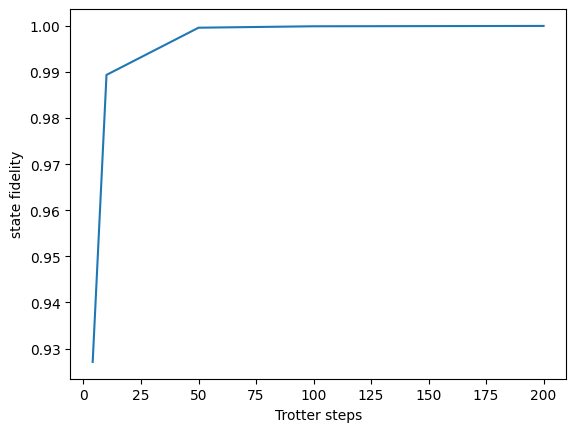

In [10]:
plt.plot(num_steps_list, fidelities_list)
plt.xlabel("Trotter steps")
plt.ylabel("state fidelity")
plt.show()

In [11]:
with open("run_trotter_"+str(num_qubits)+"-qubit_dm.pkl", "wb") as f:
    pickle.dump({"num_steps_list": num_steps_list, "fid": fidelities_list, "stddev": stddevs_list}, f)

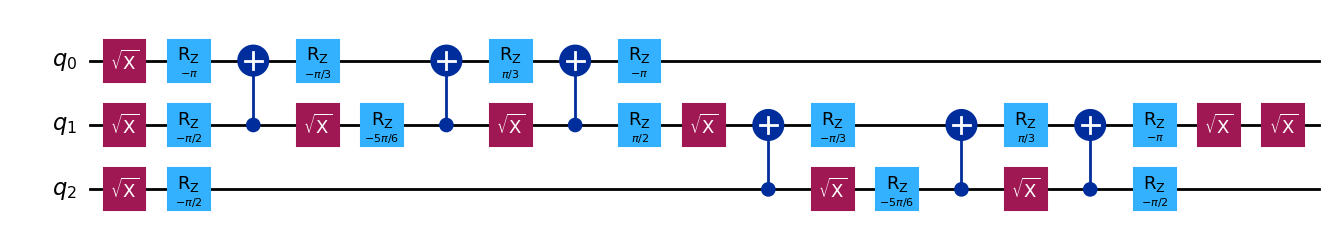

In [12]:
qr = QuantumRegister(num_qubits, 
                         name="q")
qc = QuantumCircuit(qr)

# Prepare initial state
append_initial_state(qc=qc, 
                        state_initial_str=state_initial_str)
append_block_trotter_aj(qc=qc, 
                        dt=dt,
                        num_steps=1,
                        to_instruction=False)

# Evaluate simulation at target_time (t=pi) meaning each trotter step evolves pi/trotter_steps in time
qc = qc.assign_parameters({dt: time_evolution / 1})
qc_t3 = transpile(RemoveBarriers()(qc), optimization_level=3, basis_gates=["sx", "cx", "rz"])
# qc_t3 = transpile(RemoveBarriers()(qc_t3), optimization_level=3, basis_gates=["sx", "cx", "rz"])
# qc_t3 = transpile(RemoveBarriers()(qc_t3), optimization_level=3, basis_gates=["sx", "cx", "rz"])
qc_t3.draw("mpl")

In [13]:
qc = QuantumCircuit(2)

qc.cx(0, 1)

qc.rx(2 * dt, 0)
qc.h(0)
qc.rz(- 2 * dt, 1)

qc.cx(0, 1)

qc.s(0)
qc.h(0)
qc.rz(- 2 * dt, 1)

qc.cx(0, 1)

qc.rx(- np.pi / 2, 0)
qc.rx(np.pi / 2, 1)

time_evolution = np.pi / 2
qc = qc.assign_parameters({dt: time_evolution / 1})

from qiskit.quantum_info import Operator
U = Operator(qc)
# print(U.data) 

U.draw("latex")
# qc.save_unitary()

# result = simulator_ideal.run(qc,
#                              shots=0,
#                             ).result()
# result.get_unitary(qc)

<IPython.core.display.Latex object>